<a href="https://colab.research.google.com/github/karl-gardner/ml_code_reviews/blob/main/dtc_weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from IPython.display import Image
import graphviz
from graphviz import nohtml

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1300, n_features=4,n_informative=2, n_redundant=0, random_state=0, shuffle=True)

np.random.seed(12)
indices = np.random.permutation(X.shape[0])
training_idx, test_idx = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_test = X[training_idx], X[test_idx]
y_train, y_test = y[training_idx], y[test_idx]

In [3]:
class Node():
    def __init__(self, info, left=None, right=None):
        ''' constructor '''

        # save info for nodes that are instantiated
        self.info = info
        self.left = left
        self.right = right

In [4]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, min_samples_leaf = 1, max_depth=4, min_impurity_decrease=0):
        """A decision tree classifier.

        min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node

        min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.

        max_depth : int, default=4
        The maximum depth of the tree, where index starts at 1 for the root node. For a tree consisting
        of just a root node put max_depth=1

        min_impurity_decrease : float, default=0.0

        A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
        The weighted impurity decrease equation is the following:

        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)

        where N is the total number of samples,
        N_t is the number of samples at the current node,
        N_t_L is the number of samples in the left child,
        and N_t_R is the number of samples in the right child.

        N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.
        """

        # initialize the root of the tree
        self.root = None

        # stopping conditions for the regression tree
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease

    def build_tree(self, X, Y, cur_depth=1):
        ''' recursive function to build the tree '''
        # print(f"Y values in build_tree: {Y}")
        best_split = {}
        # split until stopping conditions are not met
        if X.shape[0]>=self.min_samples_split and cur_depth<self.max_depth:
            # find the best split
            best_split = self.get_best_split(X, Y)
            # check if impurity decrease is higher than the min_impurity_decrease
            if best_split["imp_dec"]>=self.min_impurity_decrease:
                # split dataset into left and right constituents
                left_bool = X[:, best_split["feature_index"]] <= best_split["threshold"]
                X_left, Y_left = X[left_bool], [Y[0][left_bool], Y[1][left_bool]]
                X_right, Y_right = X[~left_bool], [Y[0][~left_bool], Y[1][~left_bool]]
                # recur left
                left_subtree = self.build_tree(X_left, Y_left, cur_depth+1)
                # recur right
                right_subtree = self.build_tree(X_right, Y_right, cur_depth+1)
                # return decision node
                return Node(best_split, left_subtree, right_subtree)

        # compute leaf node and add to dictionary
        best_split["values"] = Y
        # return leaf node
        return Node(best_split)

    def get_best_split(self, X, Y):
        ''' function to find the best split '''
        # dictionary to store the best split
        best_split = {"imp_dec": -1}
        # loop over all the features
        for feature_index in range(X.shape[1]):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                # Split target array into two parts
                left_bool = X[:, feature_index] <= threshold
                Y_left = [Y[0][left_bool], Y[1][left_bool]]
                Y_right = [Y[0][~left_bool], Y[1][~left_bool]]
                # check if childs are greater than min_samples_leaf
                if len(Y_left[0])>=self.min_samples_leaf and len(Y_right[0])>=self.min_samples_leaf:
                    # compute information gain (impurity decrease) with gini impurity measure
                    N, N_t, N_t_L, N_t_R = np.sum(self.sample_weight), np.sum(Y[1]), np.sum(Y_left[1]), np.sum(Y_right[1])
                    imp_dec = N_t/N*(self.gini(Y)-N_t_L/N_t*self.gini(Y_left)-N_t_R/N_t*self.gini(Y_right))
                    # if impurity decrease (variance reduction) > best_split["imp_dec"] then update it:
                    if imp_dec > best_split["imp_dec"]:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["imp_dec"] = imp_dec

        # return best split
        return best_split
    def gini(self, Y):
        # Applies gini index formula on page 309 in "Elements of Statistical Learning"
        classes = np.unique(Y[0])
        probas = np.array([np.sum(Y[1][Y[0]==k])/np.sum(Y[1]) for k in classes])
        return np.sum(probas*(1-probas))

    def fit(self, X, Y, sample_weight = None):
        self.classes = np.unique(Y)
        self.sample_weight = sample_weight if np.any(sample_weight) else np.full((len(Y),), 1/len(Y))
        Y = [Y, self.sample_weight]
        self.root = self.build_tree(X,Y)
        return self

    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        if "values" in tree.info:
            return tree.info["values"]
        feature_val = x[tree.info["feature_index"]]
        if feature_val<=tree.info["threshold"]:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    def predict(self, X):
        ''' function to predict a single data point '''
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def predict_proba(self, X):
        probas = np.zeros((len(X), len(self.classes)))
        for i, x in enumerate(X):
            leaf_values = self.make_prediction(x, self.root)
            for k in self.classes:
                probas[i, k] = np.sum(leaf_values[1][leaf_values[0] == k])/np.sum(leaf_values[1])
        return probas

    def save_tree(self, tree = None, i = 0, filename = "decision_tree"):
        if i== 0:
            tree = self.root
            self.g = graphviz.Digraph('g', filename='btree.gv',
                     node_attr={'shape': 'record', 'height': '.1'}, format="png")
        if tree:
            if "values" in tree.info:
                self.g.node(f"node{i}", nohtml(
                    f"<f0> |<f1> {np.bincount(tree.info['values'][0]).argmax():.0f}|<f2>"))
            else:
                self.g.node(f"node{i}", nohtml(
                    f"<f0> |<f1> x[{tree.info['feature_index']}]≤{tree.info['threshold']:.3f}|<f2>"))
            if i > 0:
                self.g.edge(f"node{int((i-1)/2)}:{'f2' if i%2==0 else 'f0'}", f"node{i}:f1")
            self.save_tree(tree.left, 2*i+1)
            self.save_tree(tree.right, 2*i+2)

        if i == 0: self.g.render(filename)

In [5]:
clf = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_probas = clf.predict_proba(X_test)

print(f"accuracy = {np.sum(y_pred == y_test)/len(y_test)}")

sample_weights = np.full((len(y_train),), 1/len(y_train))
sample_weights[0:500] = 0.1
weighted = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train, sample_weights)
y_pred = weighted.predict(X_test)
y_probas = weighted.predict_proba(X_test)

print(f"accuracy = {np.sum(y_pred == y_test)/len(y_test)}")

accuracy = 0.8923076923076924
accuracy = 0.8769230769230769


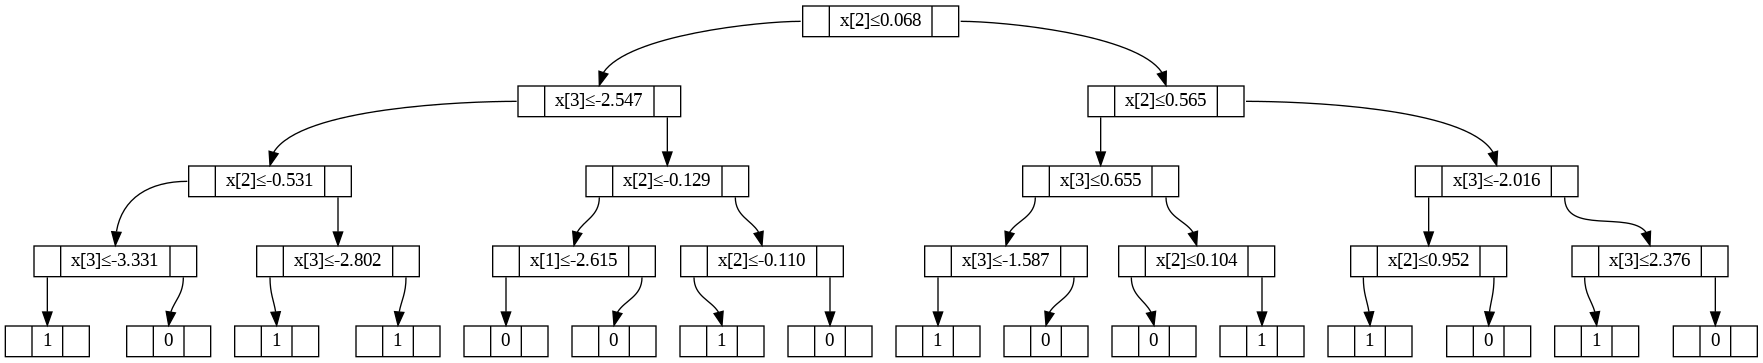

In [6]:
clf.save_tree()
Image("decision_tree.png")

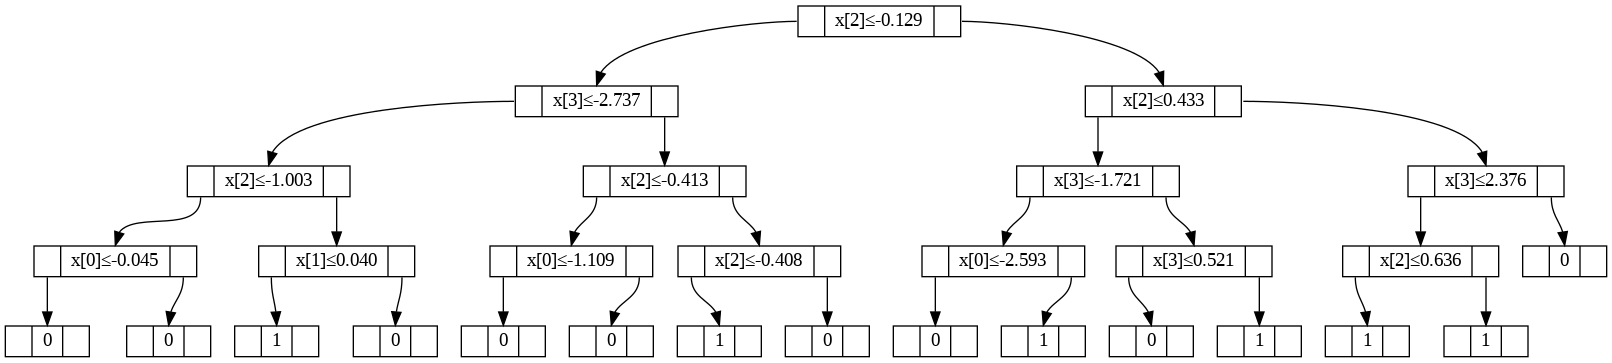

In [7]:
weighted.save_tree(filename="weighted")
Image("weighted.png")